# Vesuvius Challenge - Ink Detection
The Vesuvius Challenge: Ink Detection on Kaggle is part of a larger effort to unlock the secrets of 3000 year old Roman scrolls carbonized by the eruption of Mount Vesuvius. The goal is to detect ink from 3D X-ray scans of fragments of these scrolls, which are too fragile to be unrolled physically. The competition focuses on using machine learning models to distinguish inked areas from the papyrus material, even though both have similar densities.

High-resolution 3D X-ray scans and infrared images of the scroll fragments, along with labeled binary masks that indicate where ink is present is provided to the participants. The challenge is to build models capable of accurately detecting the ink using this data, potentially contributing to the broader goal of "reading" the intact scrolls without damaging them.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

## Hyperparameter Initiallization

In [2]:
buffer = 16
z_dim = 33
z_start = 0
default_height = 4000 #better for a available resources 
batch_size = 32
mixed_precision = False

## Inititialize the Data
### Helper Functions

In [3]:
def resize(img):
    width, height = img.size
    aspect_ratio = width / height
    new_width = int(default_height * aspect_ratio)
    new_size = (new_width, default_height)
    img = img.resize(new_size)
    return img
    
def load_mask(path):
    img = Image.open(f"{path}/mask.png").convert('1')
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

def load_labels(path):
    img = Image.open(f"{path}/inklabels.png")
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

## Visualize the data

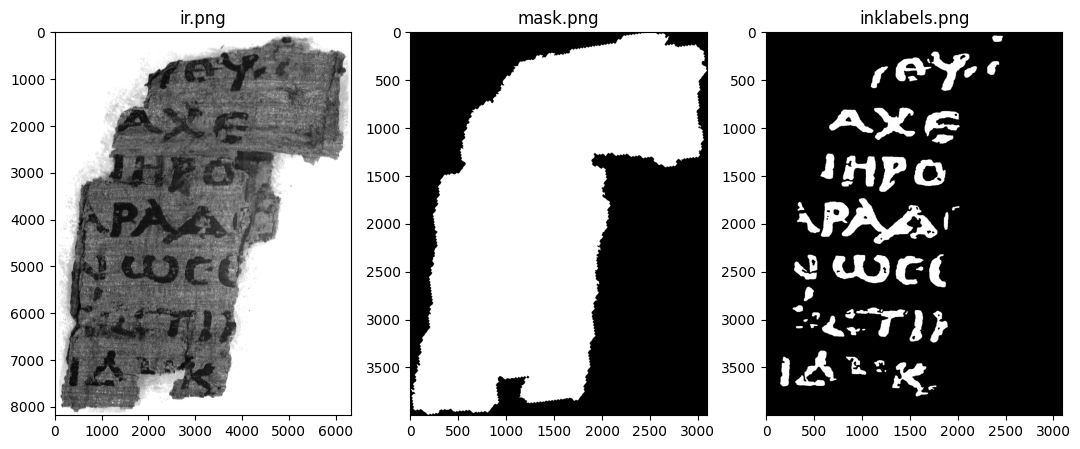

In [4]:
path = '/kaggle/input/vesuvius-challenge-ink-detection/'


mask = load_mask(f'{path}/train/1')
labels = load_labels(f'{path}/train/1')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 25))
ax1.set_title("ir.png")
ax1.imshow(Image.open(f'{path}/train/1/ir.png'), cmap="gray")
ax2.set_title("mask.png")
ax2.imshow(mask, cmap='gray')
ax3.set_title("inklabels.png")
ax3.imshow(labels, cmap='gray')
plt.show()

This image displays three side-by-side visualizations of data related to the Vesuvius Challenge: Ink Detection competition:

* IR Image (ir.png): The infrared image clearly reveals portions of the ancient writing. Letters and symbols are visible, giving more context to the fragment and where the ink might be located. The grayscale allows you to see varying levels of intensity that likely correspond to differences in material composition (such as ink and papyrus), which the machine learning models can use for prediction.
* Mask Image (mask.png): This mask remains unchanged and continues to define the area of the fragment that is being examined. The white portion represents the fragment, while the black background is excluded from analysis.
* Ink Labels (inklabels.png): The ink labels are similar to the previous image but match more closely with the IR image's visible writing. The labels are binary, showing the model's target areas for detecting the presence of ink. The alignment between the visible writing in the IR image and the labeled ink areas helps in refining model predictions.

Overall, this set of images helps train models to identify the subtle ink markings on the fragile ancient fragments. By leveraging both visual and labeled data, the models are better equipped to detect hidden or faint ink patterns that aren't easily visible to the naked eye.

Labels 1: (4000, 3094), <dtype: 'bool'>
Mask 1: (4000, 3094), <dtype: 'bool'>


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Labels 2: (4000, 2563), <dtype: 'bool'>
Mask 2: (4000, 2563), <dtype: 'bool'>
Labels 3: (4000, 2760), <dtype: 'bool'>
Mask 3: (4000, 2760), <dtype: 'bool'>


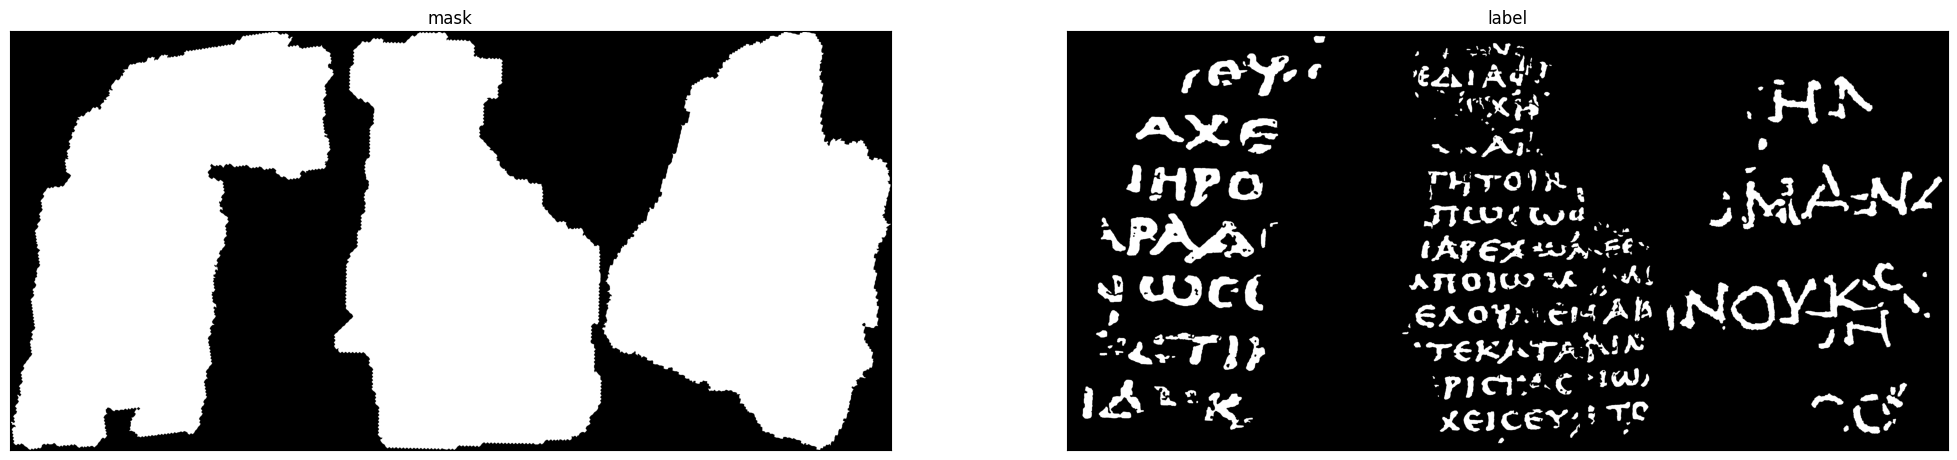

In [5]:
print(f"Labels 1: {labels.shape}, {labels.dtype}")
print(f"Mask 1: {mask.shape}, {mask.dtype}")
for i in range(2,4):
    lab = load_labels(f'{path}/train/{i}')
    print(f"Labels {i}: {lab.shape}, {lab.dtype}")
    labels = tf.concat([labels, lab], axis=1)
    
    mas = load_mask(f'{path}/train/{i}')
    print(f"Mask {i}: {mas.shape}, {mas.dtype}")
    mask = tf.concat([mask, mas], axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 13))
ax1.imshow(mask, cmap='gray')
ax1.set_title("mask")
ax1.set_xticks([]); ax1.set_yticks([])
ax2.imshow(labels, cmap='gray')
ax2.set_title("label")
ax2.set_xticks([]); ax2.set_yticks([])

del lab
del mas

It first loads the mask (defining the areas of interest) and the label data (defining inked regions) from the first training set, printing their shapes and data types. Then, it concatenates the mask and label data from additional fragments (2 and 3), extending the data along the horizontal axis. Finally, the combined mask and label images are displayed side by side in grayscale for visualization, helping to understand the ink regions across multiple fragments. The code also manages memory by deleting temporary variables after use to optimize resource consumption.

In [6]:
def load_volume(path):
    #z_slices_fnames = sorted(glob.glob(f"{path}/surface_volume/*.tif"))[z_start:z_start + z_dim]
    z_slices_fnames = sorted(glob.glob(f"{path}/surface_volume/*.tif"))
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        if z%2==0:  # Take every other or every third image to help reduce the dataset size
            img = Image.open(filename)
            img = resize(img)
            z_slice = np.array(img, dtype="float32")
            z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

In [7]:
volume = load_volume(f'{path}/train/1')
print(f"Volume 1: {volume.shape}, {volume.dtype}")
for i in range(2,4):
    vol = load_volume(f'{path}/train/{i}')
    print(f"Volume {i}: {vol.shape}, {vol.dtype}")
    volume = tf.concat([volume, vol], axis = 1)
print(f"total volume: {volume.shape}")

del vol

65it [01:04,  1.01it/s]


Volume 1: (4000, 3094, 33), <dtype: 'float32'>


65it [04:56,  4.55s/it]


Volume 2: (4000, 2563, 33), <dtype: 'float32'>


65it [00:48,  1.33it/s]


Volume 3: (4000, 2760, 33), <dtype: 'float32'>
total volume: (4000, 8417, 33)


First, the code collects the filenames of .tif images from the given path, selects a range of z-slices, and processes each image slice by resizing it and converting it to float values. These slices are then stacked along a new axis to form a 3D tensor. The process is repeated for each fragment, and the volumes are concatenated horizontally (along axis 1) to form a unified dataset. Finally, the total volume shape is printed to confirm the dimensions, and temporary variables are deleted to manage memory. This setup helps create a comprehensive 3D representation of the fragments for further analysis.

## Example of one of the layers

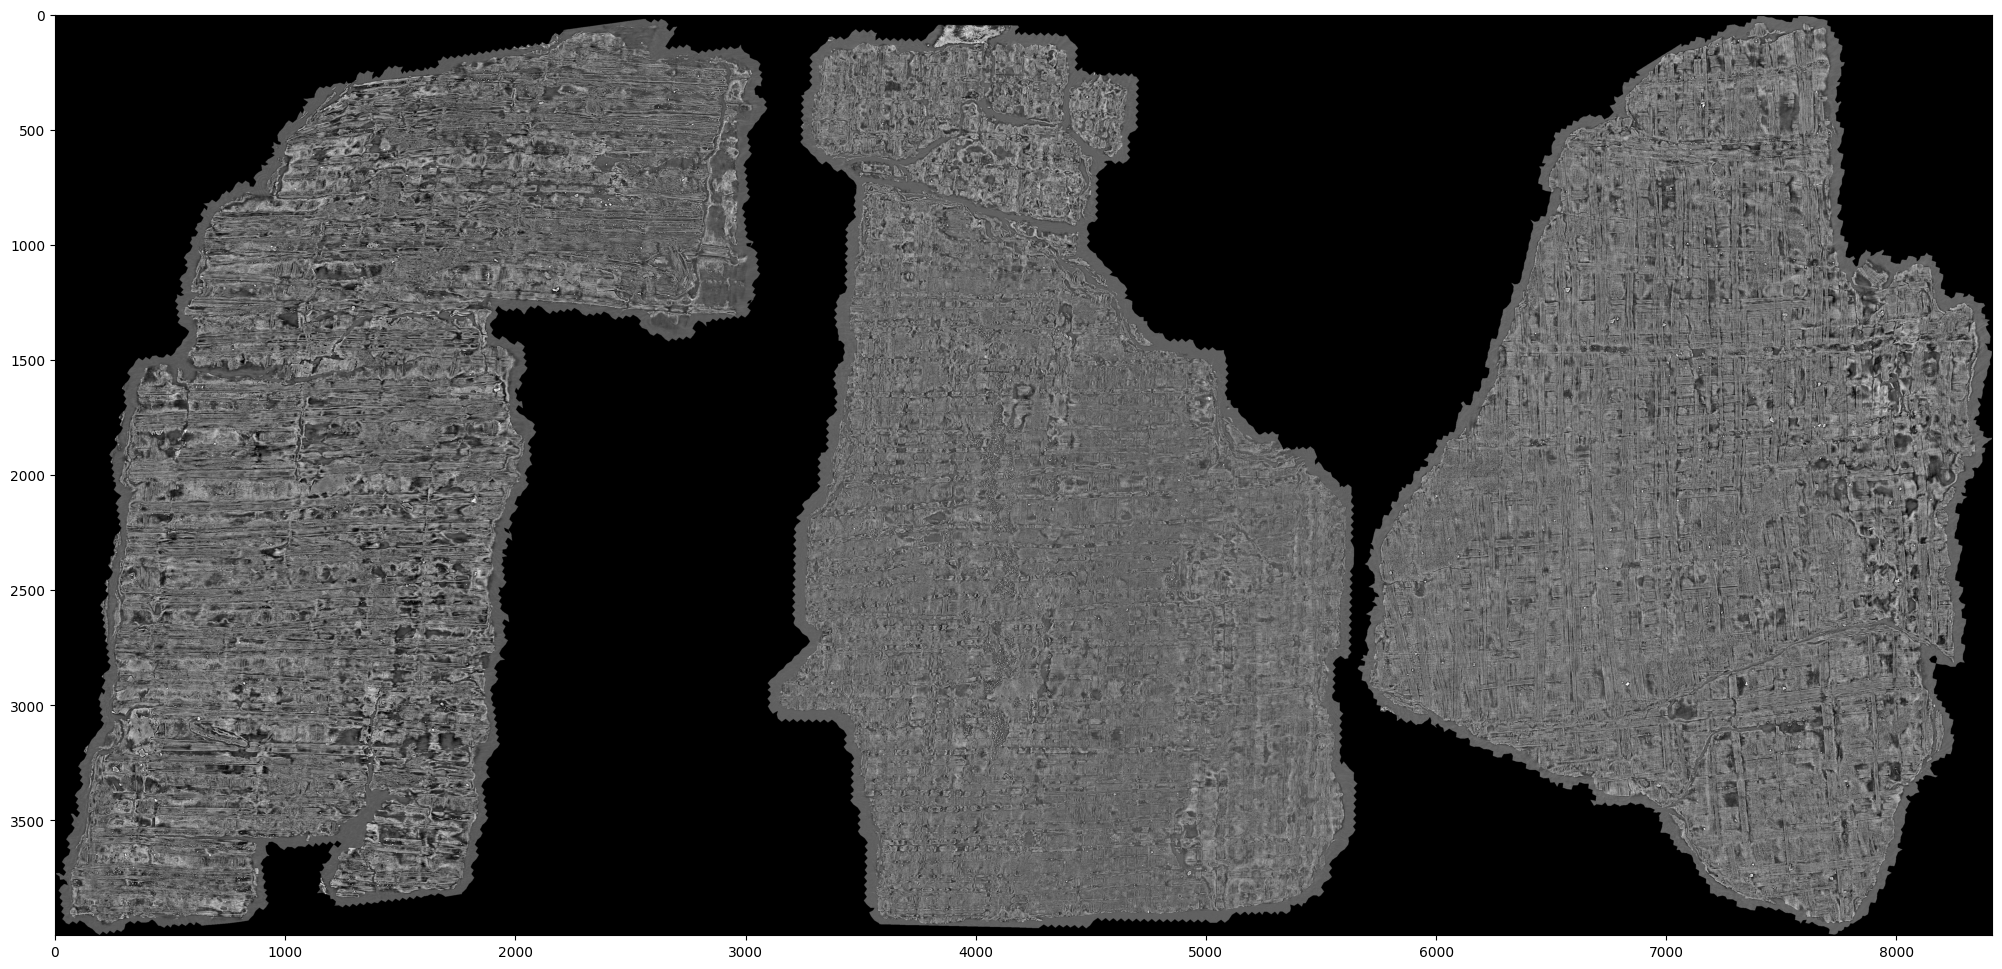

In [8]:
fig, ax = plt.subplots(figsize=(25, 13))
ax.imshow(volume[:, :, 10], cmap='gray')
plt.show()

## Helper Functions for identifying the areas within the masks and labels

In [9]:
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=buffer, maxval=shape[0] - buffer - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=buffer, maxval=shape[1] - buffer - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - buffer <= x <= val_location[0] + val_zone_size[0] + buffer
    y_match = val_location[1] - buffer <= y <= val_location[1] + val_zone_size[1] + buffer
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)


### Filter out values in the test area
It starts by defining val_location and val_zone_size as constants that likely specify the validation region's location and size. The function sample_random_location_train generates random locations within the mask's shape, and is_in_mask_train checks if these random locations fall within a valid masked zone. The dataset train_locations_ds is created using tf.data.Dataset to continuously generate random locations, which are then filtered by is_proper_train_location to ensure only appropriate locations are kept for training. This setup is part of the data pipeline to dynamically sample training data points from valid areas of the mask, improving training efficiency by focusing on relevant regions.

In [10]:
val_location = (2500, 100)
val_zone_size = (800, 2000)
val_location = tf.constant([2500, 100], dtype=tf.int32)
val_zone_size = tf.constant([800, 2000], dtype=tf.int32)

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

### Plot 500 locations in the masks, outside of the testing area

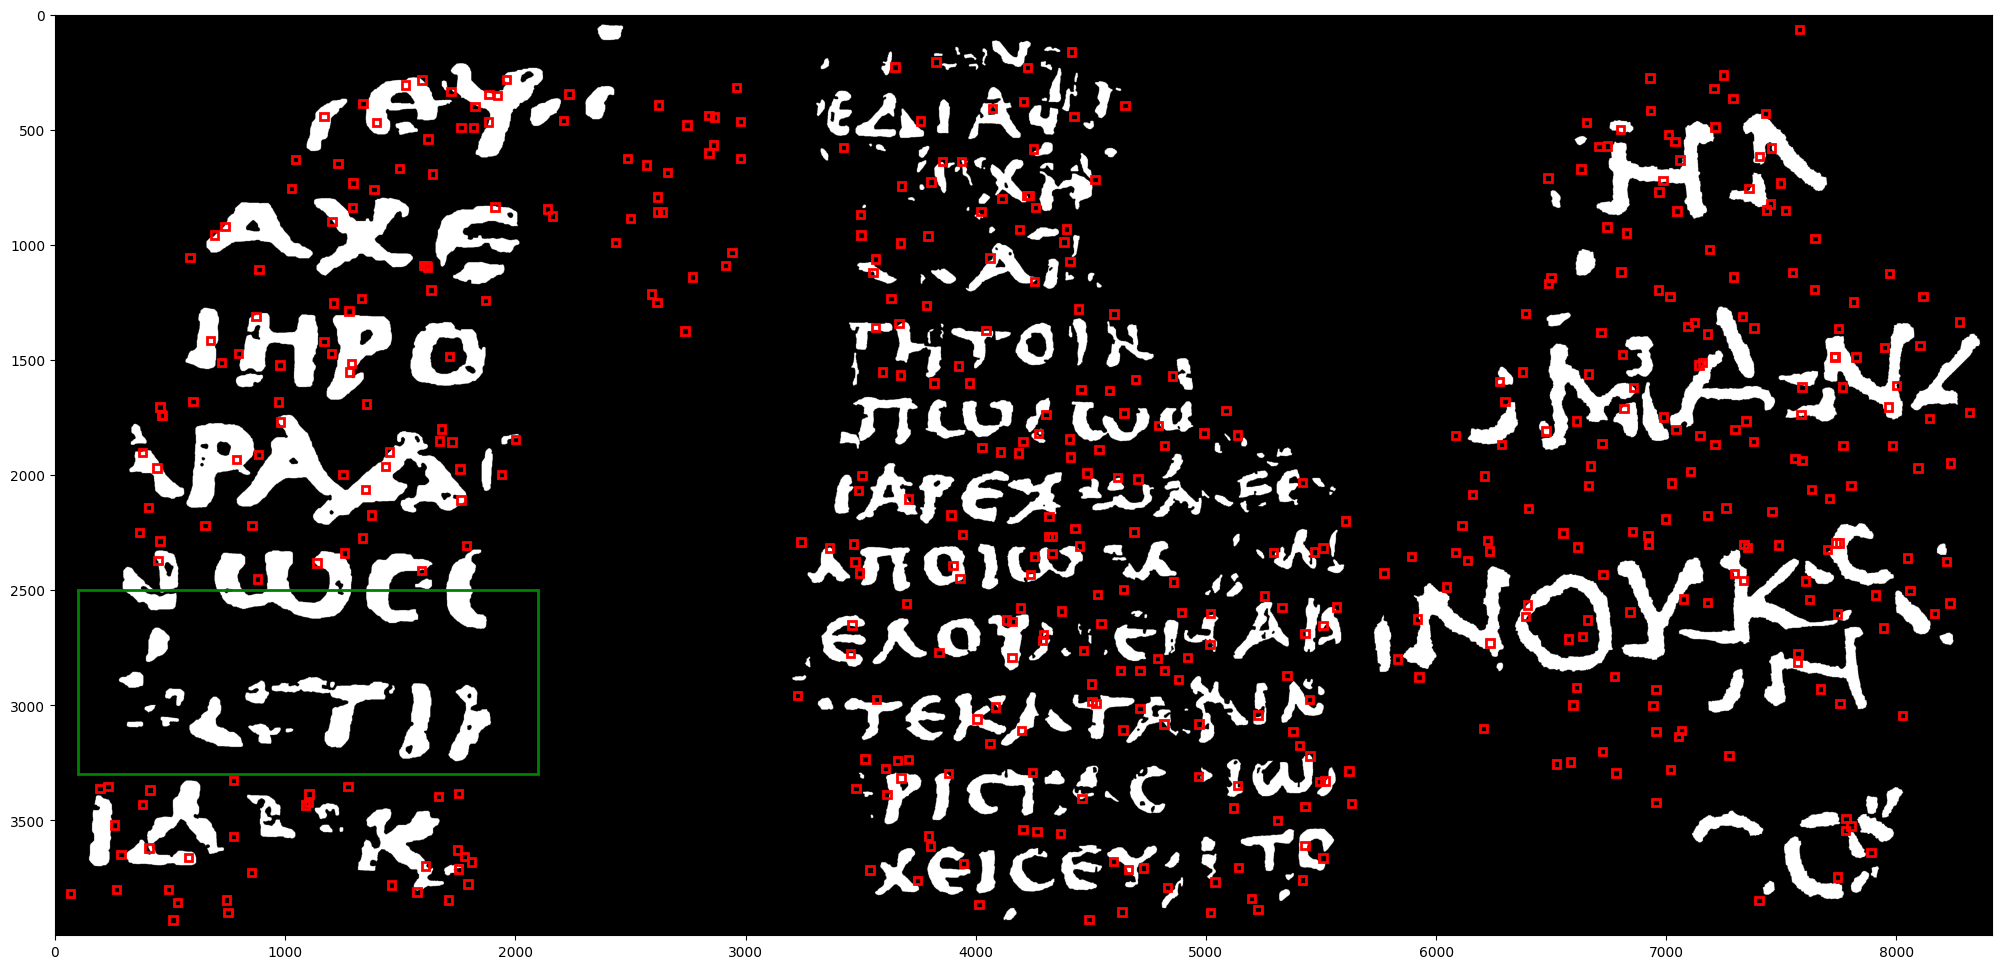

In [11]:
fig, ax = plt.subplots(figsize=(25,13))
ax.imshow(labels, cmap='gray')

for x, y in train_locations_ds.take(500):
    patch = patches.Rectangle([y - buffer, x - buffer], 2 * buffer, 2 * buffer, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

In [12]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-buffer:x+buffer, y-buffer:y+buffer, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-buffer:x+buffer, y-buffer:y+buffer]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

shuffle_buffer_size = batch_size * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(batch_size)

In [13]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")

subvolume shape: (32, 32, 33)
label_batch shape: (32, 32, 1)


In [14]:
val_locations_stride = buffer
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(batch_size)

The function extract_subvolume retrieves a subvolume from the larger 3D volume at a given (x, y) location, normalizing its values. Similarly, extract_labels extracts the corresponding 2D label region from the labels dataset. Both subvolumes and labels are generated at the same location via extract_subvolume_and_label. For training, random locations are continuously sampled and used to generate subvolumes and labels, which are batched and pre-fetched for efficiency. Validation locations are predefined within a specific zone, iterating over grid points defined by val_location and val_zone_size. These validation subvolumes and labels are similarly pre-processed and batched. The approach dynamically generates subvolumes to improve the training process while focusing on masked regions and ensuring data is efficiently loaded for both training and validation steps.

## Augment the Data

This code applies data augmentation to the training dataset for the Vesuvius Challenge: Ink Detection using TensorFlow/Keras. It defines an augmentation pipeline using keras.Sequential, where a single augmentation layer RandomContrast(0.2) is applied, randomly adjusting the contrast of the training images by up to 20%. The augment_train_data function is used to apply this augmentation to the subvolume data, leaving the corresponding labels unchanged. The train_ds dataset is then augmented by mapping this function over the dataset, with prefetching enabled to improve performance during training. This approach adds variation to the training data, helping the model generalize better by simulating different contrast levels in the input images.

In [15]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Define the model
This model employs a U-Net-like structure, comprising two main phases: downsampling and upsampling. The downsampling phase captures features at various resolutions, using separable convolutions for parameter efficiency and batch normalization for stabilizing learning. This is followed by residual connections that help preserve spatial information across layers, which is crucial for maintaining context in the segmentation task. The upsampling phase restores the spatial resolution while combining features from the downsampling path, allowing the model to make pixel-level predictions effectively. This architecture is particularly advantageous in tasks involving complex features, as it facilitates a deeper understanding of the input data while reducing the risk of overfitting.


In [16]:
def conv_block(x, filters, kernel_size=3, strides=1, padding="same", activation="relu"):
    x = layers.Activation(activation)(x)
    x = layers.SeparableConv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    return x

def conv_transpose_block(x, filters, kernel_size=3, strides=1, padding="same", activation="relu"):
    x = layers.Activation(activation)(x)
    x = layers.Conv2DTranspose(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    return x

def get_model(input_shape):
    inputs = keras.Input(input_shape)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x
    # Downsampling
    for filters in [128, 256]:
        x = conv_block(x, filters)
        x = conv_block(x, filters)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    # Upsampling
    for filters in [256, 128, 64]:
        x = conv_transpose_block(x, filters)
        x = conv_transpose_block(x, filters)
        x = layers.UpSampling2D(2)(x)
        
        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    model = keras.Model(inputs, outputs)
    
    return model

### Generate the model and gradient

In [17]:
if mixed_precision:
    keras.mixed_precision.set_global_policy('mixed_float16')

model = get_model((buffer * 2, buffer * 2, z_dim))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], jit_compile=False)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 33)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │     19,072 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 16, 16,    │      8,896 │ activation[0][0]  │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 16, 16,    │     17,664 │ activation_1[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 128) │          0 │ max_pooling2d[0]… │
│                     │                   │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 128) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 8, 8, 256) │     34,176 │ activation_2[0][… │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 8, 8, 256) │     68,096 │ activation_3[0][… │
│ (SeparableConv2D)   │                   │            │                 

 Total params: 2,037,185 (7.77 MB)

 Trainable params: 2,033,729 (7.76 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [18]:
model.fit(augmented_train_ds, validation_data=val_ds, epochs=50, steps_per_epoch=1000)
model.save("model.keras")

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.8297 - loss: 0.5314 - val_accuracy: 0.6188 - val_loss: 0.6525
Epoch 2/50
   5/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.8385 - loss: 0.4533

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8372 - loss: 0.4279 - val_accuracy: 0.8070 - val_loss: 0.5049
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8393 - loss: 0.4113 - val_accuracy: 0.8197 - val_loss: 0.4530
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8423 - loss: 0.4011 - val_accuracy: 0.6329 - val_loss: 0.6300
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8442 - loss: 0.3930 - val_accuracy: 0.7815 - val_loss: 0.4685
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8478 - loss: 0.3860 - val_accuracy: 0.8202 - val_loss: 0.4582
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8499 - loss: 0.3770 - val_accuracy: 0.7640 - val_loss: 0.4937
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8504 - loss: 0.3749 - val_accuracy: 0.8131 - val_loss: 0.4556
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.8458 - loss: 0.37

### Memory Cleanup

In [19]:
del volume
del mask
del labels
del train_ds
del val_ds

# Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

0

In [20]:
model = keras.models.load_model("model.keras")

## Run the model on the test set
The compute_predictions_map function processes test data to generate a predictions map for a given volume. It begins by loading the test volume and associated mask from the specified path. The function defines a stride based on the buffer value and generates a list of test locations, representing points within the volume from which patches will be extracted for prediction. Before proceeding, it filters these locations using a function that checks if they fall within the mask area, ensuring that only relevant patches are analyzed.

Next, the function creates datasets for the test locations and corresponding subvolumes, utilizing TensorFlow’s data pipeline for efficient handling. It initializes prediction maps to accumulate predictions and counts for averaging later. The predictions are computed in batches for efficiency, and the results are added to the corresponding locations in the predictions map, which is finally averaged to obtain a smoothed prediction output.

Finally it creates a heatmap of the predicted values to guage the model and visualize the result.

In [21]:
def compute_predictions_map(path):
    print(f"Load data for {path}")

    test_volume = load_volume(path)
    test_mask = load_mask(path)

    stride = buffer // 2
    test_locations = [
        (x, y) for x in range(buffer, test_volume.shape[0] - buffer, stride)
                for y in range(buffer, test_volume.shape[1] - buffer, stride)
    ]

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # Filter locations by mask and extract subvolumes
    test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations) \
        .filter(lambda loc: is_in_masked_zone(loc, test_mask))
    test_ds = test_locations_ds.map(lambda loc: extract_subvolume(loc, test_volume), 
                                    num_parallel_calls=tf.data.AUTOTUNE)

    # Initialize maps for predictions and counts
    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype="float16")
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype="int8")

    print(f"Compute predictions")
    
    # Compute predictions and update maps
    for loc_batch, patch_batch in tqdm(zip(test_locations_ds.batch(batch_size), test_ds.batch(batch_size))):
        predictions = model.predict_on_batch(patch_batch)
        for (x, y), pred in zip(loc_batch, predictions):
            x_min, x_max = x - buffer, x + buffer
            y_min, y_max = y - buffer, y + buffer
            predictions_map[x_min:x_max, y_min:y_max, :] += pred
            predictions_map_counts[x_min:x_max, y_min:y_max, :] += 1

    # Normalize predictions by counts
    predictions_map /= (predictions_map_counts + 1e-7)

    return predictions_map

Load data for /kaggle/input/vesuvius-challenge-ink-detection//test/a


65it [00:23,  2.81it/s]


573872 test locations (before filtering by mask)
Compute predictions


11317it [10:12, 18.48it/s]


Load data for /kaggle/input/vesuvius-challenge-ink-detection//test/b


65it [00:42,  1.55it/s]


286192 test locations (before filtering by mask)
Compute predictions


4798it [04:19, 18.51it/s]


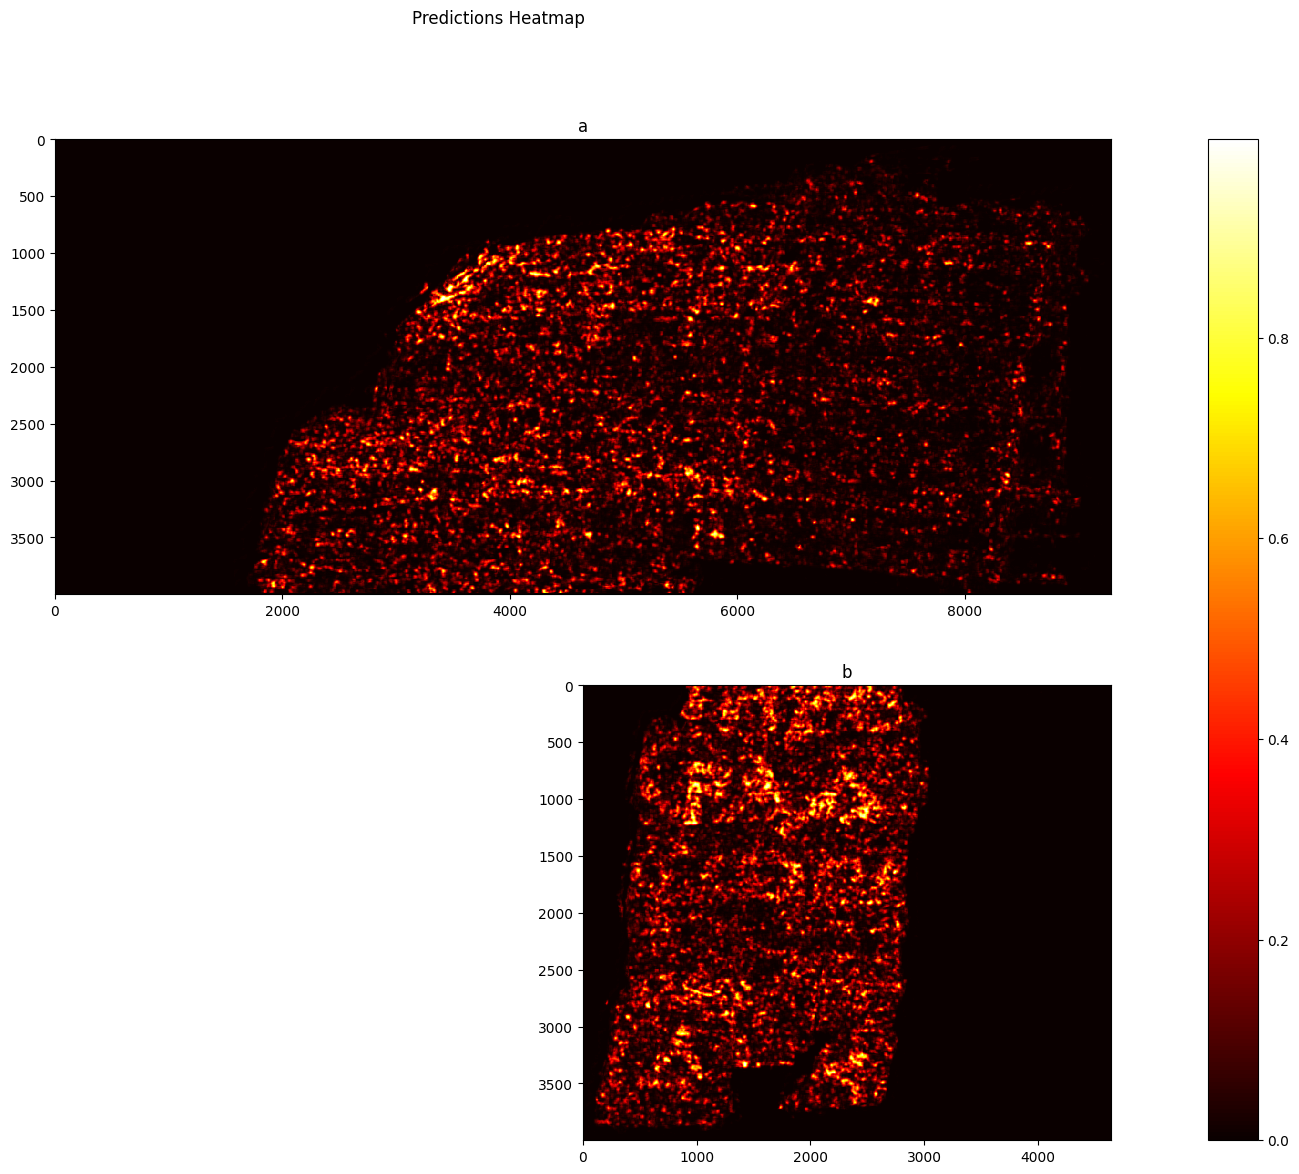

In [22]:
predictions_map_a = compute_predictions_map(f'{path}/test/a')
predictions_map_b = compute_predictions_map(f'{path}/test/b')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 13))
im1 = ax1.imshow(predictions_map_a.squeeze(), cmap="hot", interpolation="nearest")
ax1.set_title("a")
im2 = ax2.imshow(predictions_map_b.squeeze(), cmap="hot", interpolation="nearest")
ax2.set_title("b")
fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical')
plt.suptitle("Predictions Heatmap")
plt.show()
plt.close()


## Preparing the Predictions

The code snippet resizes the predicted masks (predictions_map_a and predictions_map_b) to match the original sizes of their respective ground truth masks. This is done using the resize function from the skimage library, which adjusts the dimensions of the predictions for accurate comparison and evaluation.

In [23]:
from skimage.transform import resize as resize_ski

original_size_a = Image.open(path + "/test/a/mask.png").size
predictions_map_a = resize_ski(predictions_map_a, (original_size_a[1], original_size_a[0])).squeeze()

original_size_b = Image.open(path + "/test/b/mask.png").size
predictions_map_b = resize_ski(predictions_map_b, (original_size_b[1], original_size_b[0])).squeeze()

This block defines a function called rle, which converts the resized predictions map into a run-length encoding (RLE) format. This function flattens the predictions map into a binary representation based on a specified threshold (in this case, 0.5), marking regions of interest. It identifies the starting and ending points of contiguous regions of predicted values (1s), calculates their lengths, and formats the results as a string suitable for submission in a Kaggle competition. Finally, the RLE results for both datasets are written to a CSV file named submission.csv, ready for evaluation in the competition. This approach is essential for efficient storage and transmission of segmentation results, particularly in challenges focused on image segmentation, like the Vesuvius Challenge.

In [34]:
def rle(predictions_map, threshold):
    flat_img = predictions_map.flatten()
    flat_img_ = np.where(flat_img > threshold, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [40]:

threshold = 0.25

rle_a = rle(predictions_map_a, threshold=threshold)
rle_b = rle(predictions_map_b, threshold=threshold)
print("Id,Predicted\na," + rle_a + "\nb," + rle_b, file=open('submission.csv', 'w'))

## Export and visualize the final product

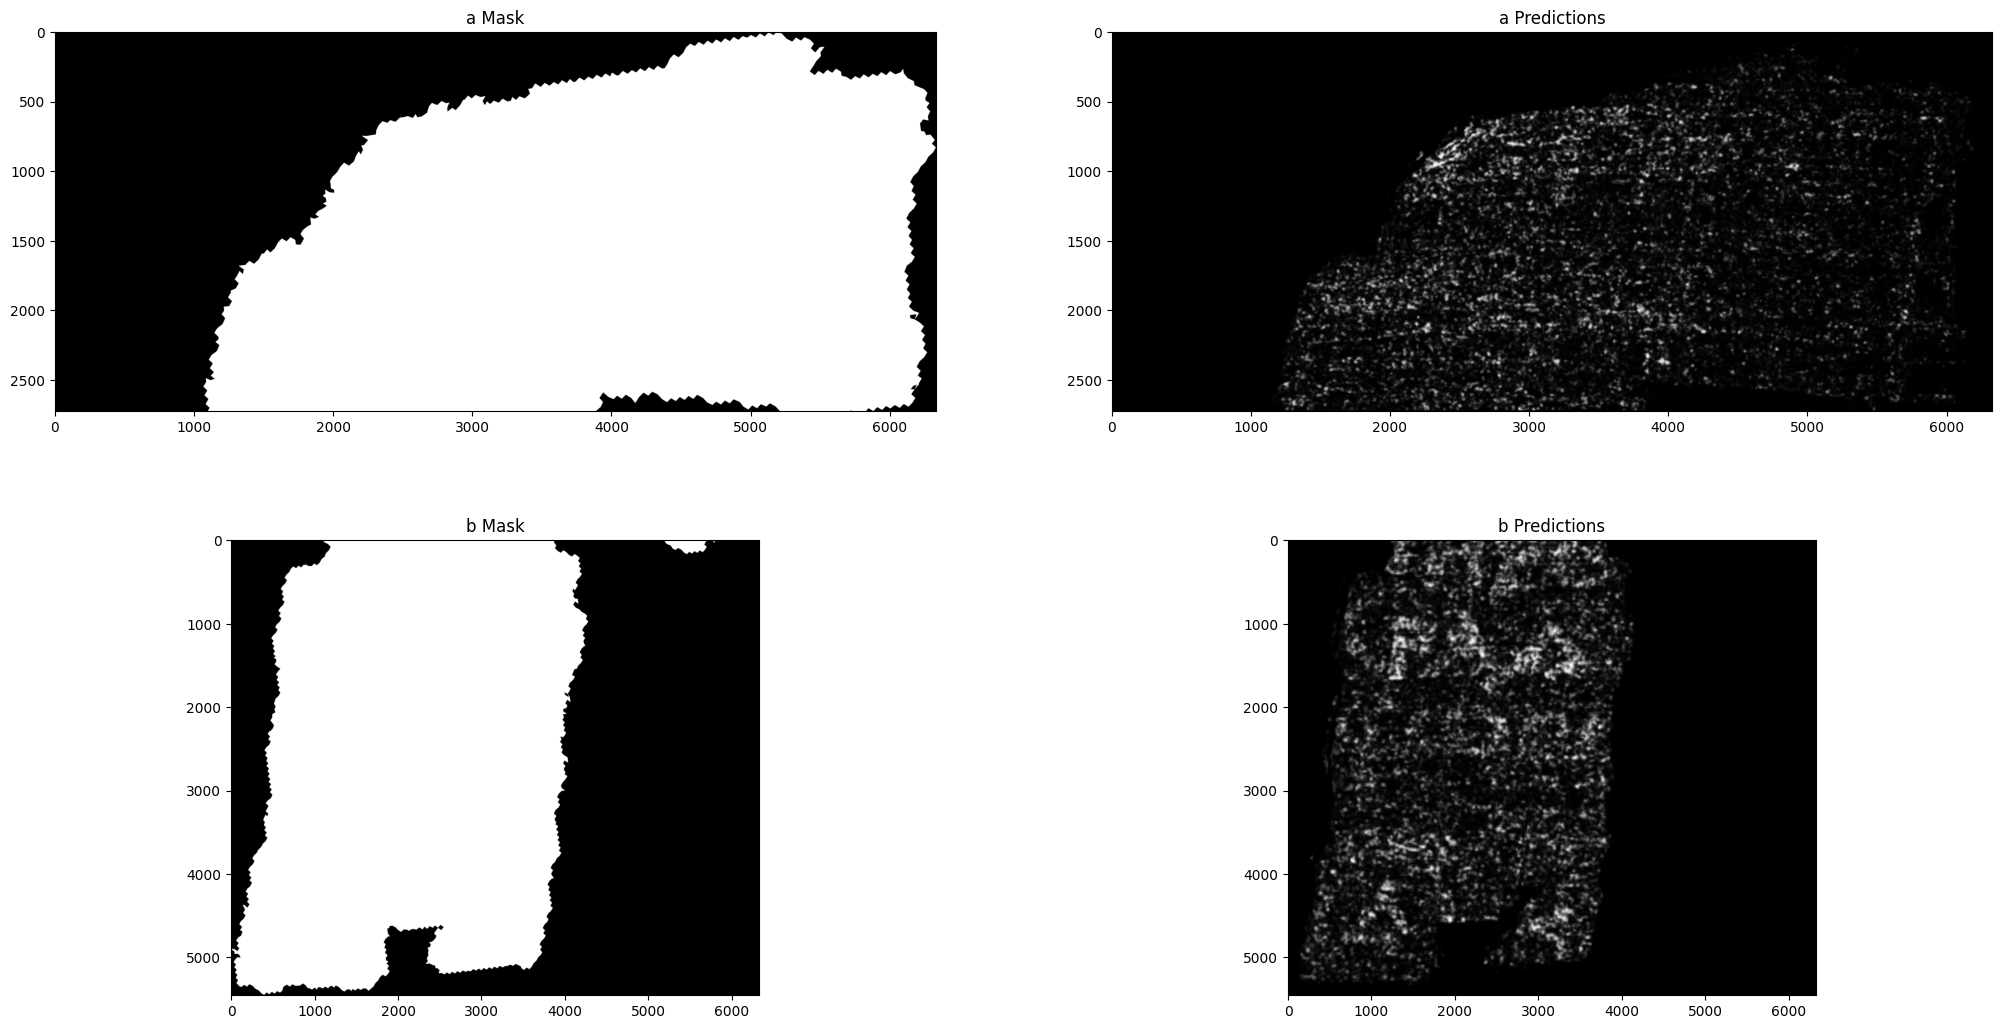

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(25, 13))
ax1, ax2, ax3, ax4 = axes.flatten() 
ax1.imshow(Image.open(path + "/test/a/mask.png"), cmap='gray')
ax1.set_title('a Mask')
ax2.imshow(predictions_map_a, cmap='gray')
ax2.set_title('a Predictions')
ax3.imshow(Image.open(path + "/test/b/mask.png"), cmap='gray')
ax3.set_title('b Mask')
ax4.imshow(predictions_map_b, cmap='gray')
ax4.set_title('b Predictions')
plt.show()

## Conclusion
While the model is designed to handle intricate tasks such as image segmentation and prediction mapping, it is also resource-intensive, demanding substantial computational power and memory. The use of TensorFlow and Keras, along with operations like convolutional layers, batch normalization, and data augmentation, further contribute to the high resource consumption. Each step in the pipeline, from loading volumes and processing patches to generating predictions and computing run-length encodings, can lead to bottlenecks when scaling for larger datasets or higher resolutionsraints of GPU memory and computational time, it becomes essential to optimize the workflow. Strategies such as reducing the image resolution, employing efficient data pipelines (e.g., using TensorFlow’s tf.data API), and minimizing batch sizes can help mitigate the resource load. Additionally, utilizing mixed precision training can significantly reduce memory usage and speed up computations without sacrificing model performance . As the complexreases, balancing model accuracy with resource efficiency will be crucial, ensuring the training and inference processes remain feasible within the available GPU time restrictions. This iterative refinement process not only enhances performance but also paves the way for applying similar methodologies to other large-scale image analysis projects .